# Compute reference embeddings

In [3]:
from setup import neurotransmitters, model, device, feat_dim, resize_size, dataset_path, curated_idx
from setup import tqdm, torch, np, os, h5py, sns, plt, tqdm
from setup import cosine_similarity, euclidean_distances
from perso_utils import get_fnames, load_image, get_latents
from DINOSim import DinoSim_pipeline, diplay_features
from napari_dinosim.utils import get_img_processing_f


if __name__=='__main__':  # Fixed: Added double underscores
    
    # Create an instance of the pipeline (not just assigning the class)
    few_shot = DinoSim_pipeline(model,
                                model.patch_size,
                                device,
                                get_img_processing_f(resize_size),
                                feat_dim, 
                                dino_image_size=resize_size
                                )

    k = 10

    files, labels = zip(*get_fnames()) # returns list(zip(np.concatenate(files), np.concatenate(labels)))
    good_files = [files[idx] for idx in curated_idx] # len = 60
    datasets = [good_files[i:i+10] for i in range(0, len(curated_idx), 10)] # list of lists of files
    good_labels = [labels[idx] for idx in curated_idx]
    _labels = [good_labels[i:i+10] for i in range(0, len(curated_idx), 10)] # list of lists of labels
    
    latent_list, label_list = [], []

    for dataset, batch_label in tqdm(zip(datasets, _labels), desc='Iterating through neurotransmitters'):
    #for d, l in tqdm(zip(good_files, good_labels), desc='Iterating through neurotransmitters'):
        # Load images and prepare data
        images = np.array([load_image(file)[0] for file in dataset]).transpose(0,2,3,1)  # Convert to numpy array
        coordinates = [(0, load_image(file)[1], load_image(file)[2]) for file in dataset]

        # Pre-compute embeddings
        few_shot.pre_compute_embeddings(
            images,  # Pass numpy array of images
            overlap=(0.5, 0.5),
            padding=(0, 0),
            crop_shape=(512, 512, 1),
            verbose=True,
            batch_size=1
        )
        
        # Set reference vectors
        few_shot.set_reference_vector(coordinates, filter=None)
        ref = few_shot.get_refs()
        
        # Get closest elements - using the correct method name
        
        close_embedding =  few_shot.get_k_closest_elements(k=k)
        #k_labels = [l for _ in range(k)]
        k_labels =  [batch_label[0] for _ in range(k)]
    
        
        # Convert to numpy for storing
        close_embedding_np = close_embedding.cpu().numpy() if isinstance(close_embedding, torch.Tensor) else close_embedding
        
        latent_list.append(close_embedding_np)
        label_list.append(k_labels)
        
        # Clean up to free memory
        few_shot.delete_precomputed_embeddings()
        few_shot.delete_references()
        
    mean_ref = np.vstack([np.mean(list, axis=0) for list in latent_list])
    # Stack all embeddings and labels
    ref_latents = np.vstack(latent_list)
    ref_labels = np.hstack(label_list)


Iterating through neurotransmitters: 0it [00:00, ?it/s]

Precomputing embeddings


100%|██████████| 40/40 [00:11<00:00,  3.41it/s]
Iterating through neurotransmitters: 1it [00:12, 12.58s/it]

Precomputing embeddings


100%|██████████| 40/40 [00:11<00:00,  3.44it/s]
Iterating through neurotransmitters: 2it [00:24, 12.47s/it]

Precomputing embeddings


100%|██████████| 40/40 [00:10<00:00,  3.64it/s]
Iterating through neurotransmitters: 3it [00:36, 12.11s/it]

Precomputing embeddings


100%|██████████| 40/40 [00:11<00:00,  3.61it/s]
Iterating through neurotransmitters: 4it [00:48, 11.99s/it]

Precomputing embeddings


100%|██████████| 40/40 [00:11<00:00,  3.58it/s]
Iterating through neurotransmitters: 5it [01:00, 11.95s/it]

Precomputing embeddings


100%|██████████| 40/40 [00:11<00:00,  3.51it/s]
Iterating through neurotransmitters: 6it [01:12, 12.07s/it]


# Compute new image's embeddings

In [4]:
new_image_index = 650

img = np.array(load_image(files[new_image_index])[0])[...,np.newaxis]#.transpose(0,2,3,1)
    
few_shot.pre_compute_embeddings(
        img,  # Pass numpy array of images
        overlap=(0.5, 0.5),
        padding=(0, 0),
        crop_shape=(512, 512, 1),
        verbose=True,
        batch_size=1
    )
    
new_img_embs = few_shot.get_embs().reshape(-1, feat_dim)
    
new_label = ['new' for _ in range(new_img_embs.shape[0])]
    
# Stack all embeddings and labels
ref_latents = np.vstack(latent_list)
ref_labels = np.hstack(label_list)
    
mean_ref = np.vstack([np.mean(list, axis=0) for list in latent_list])
mean_labs = [neurotransmitter for neurotransmitter in neurotransmitters]
    
latents = np.vstack([ref_latents, new_img_embs])  # Changed from stack to vstack for proper concatenation
labs = np.hstack([ref_labels, new_label])    # Changed from stack to hstack for proper concatenation

Precomputing embeddings


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


In [5]:
print(f'The actual EM belongs to the class: {labels[new_image_index]}')
print(f'We have {len(latent_list[0])} reference points inside each of the {len(neurotransmitters)} classes')
print(f'There are {len(mean_ref)} average reference embeddings and {len(ref_latents)} in total')

The actual EM belongs to the class: dopamine
We have 10 reference points inside each of the 6 classes
There are 6 average reference embeddings and 60 in total


# Reference embeddings visualization

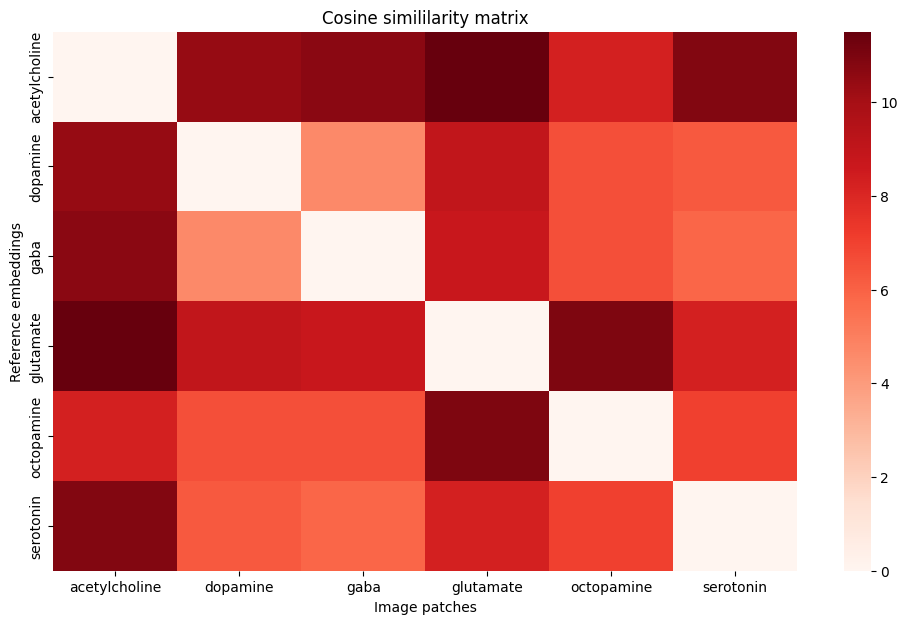

In [6]:
similarity_matrix = euclidean_distances(mean_ref, mean_ref)
plt.figure(figsize=(12,7), dpi=100)
sns.heatmap(similarity_matrix, xticklabels=mean_labs, yticklabels=mean_labs, cmap='Reds')
plt.title('Cosine simililarity matrix')
plt.xlabel('Image patches')
plt.ylabel('Reference embeddings')
plt.show()

In [7]:
diplay_features(
        np.vstack([ref_latents, np.vstack(mean_ref)]),
        np.hstack([ref_labels, np.hstack(mean_labs)]),

        include_pca=False,
        pca_nb_components=100,
        clustering=False,
        nb_clusters=6,
        nb_neighbor=10,
        min_dist=1,
        nb_components=2,
        metric='cosine'
    )

/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


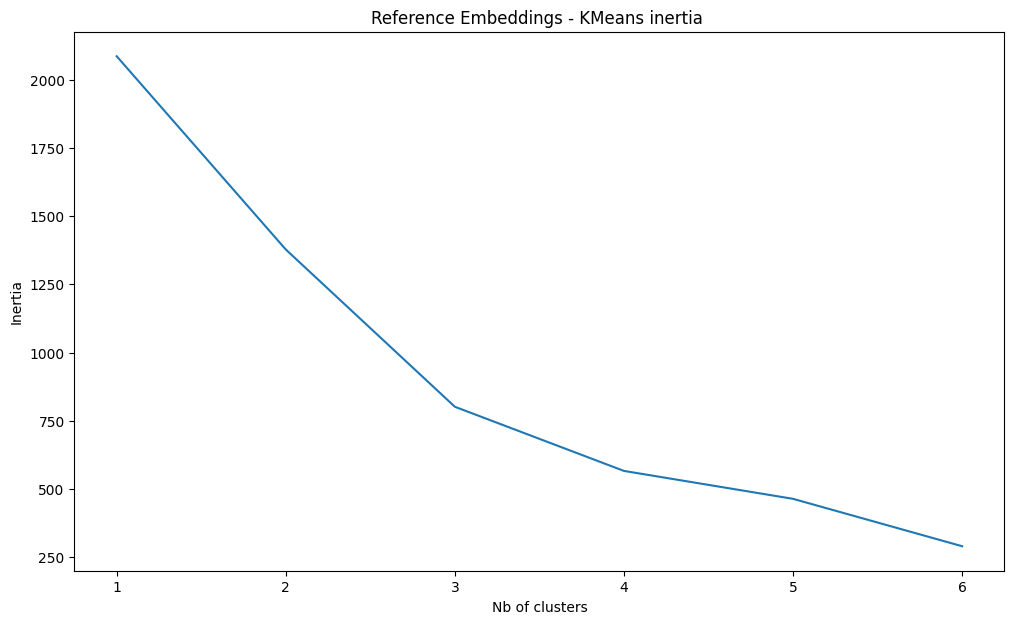

In [8]:
from sklearn.cluster import KMeans
inertia_list = []
for k in range(1,len(mean_labs)+1):
    kmeans = KMeans(n_clusters=k).fit(ref_latents)
    inertia_list.append(kmeans.inertia_)
plt.figure(figsize=(12,7),dpi=100)
plt.plot([i for i in range(1,len(mean_labs)+1)], inertia_list)
plt.title('Reference Embeddings - KMeans inertia ')
plt.ylabel('Inertia')
plt.xlabel('Nb of clusters')
plt.show()

# Results 

In [9]:
diplay_features(
        latents,
        labs,
        include_pca=False,
        pca_nb_components=100,
        clustering=False,
        nb_clusters=6,
        nb_neighbor=30,
        min_dist=1,
        nb_components=2,
        metric='cosine'
    )

/opt/anaconda3/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/opt/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



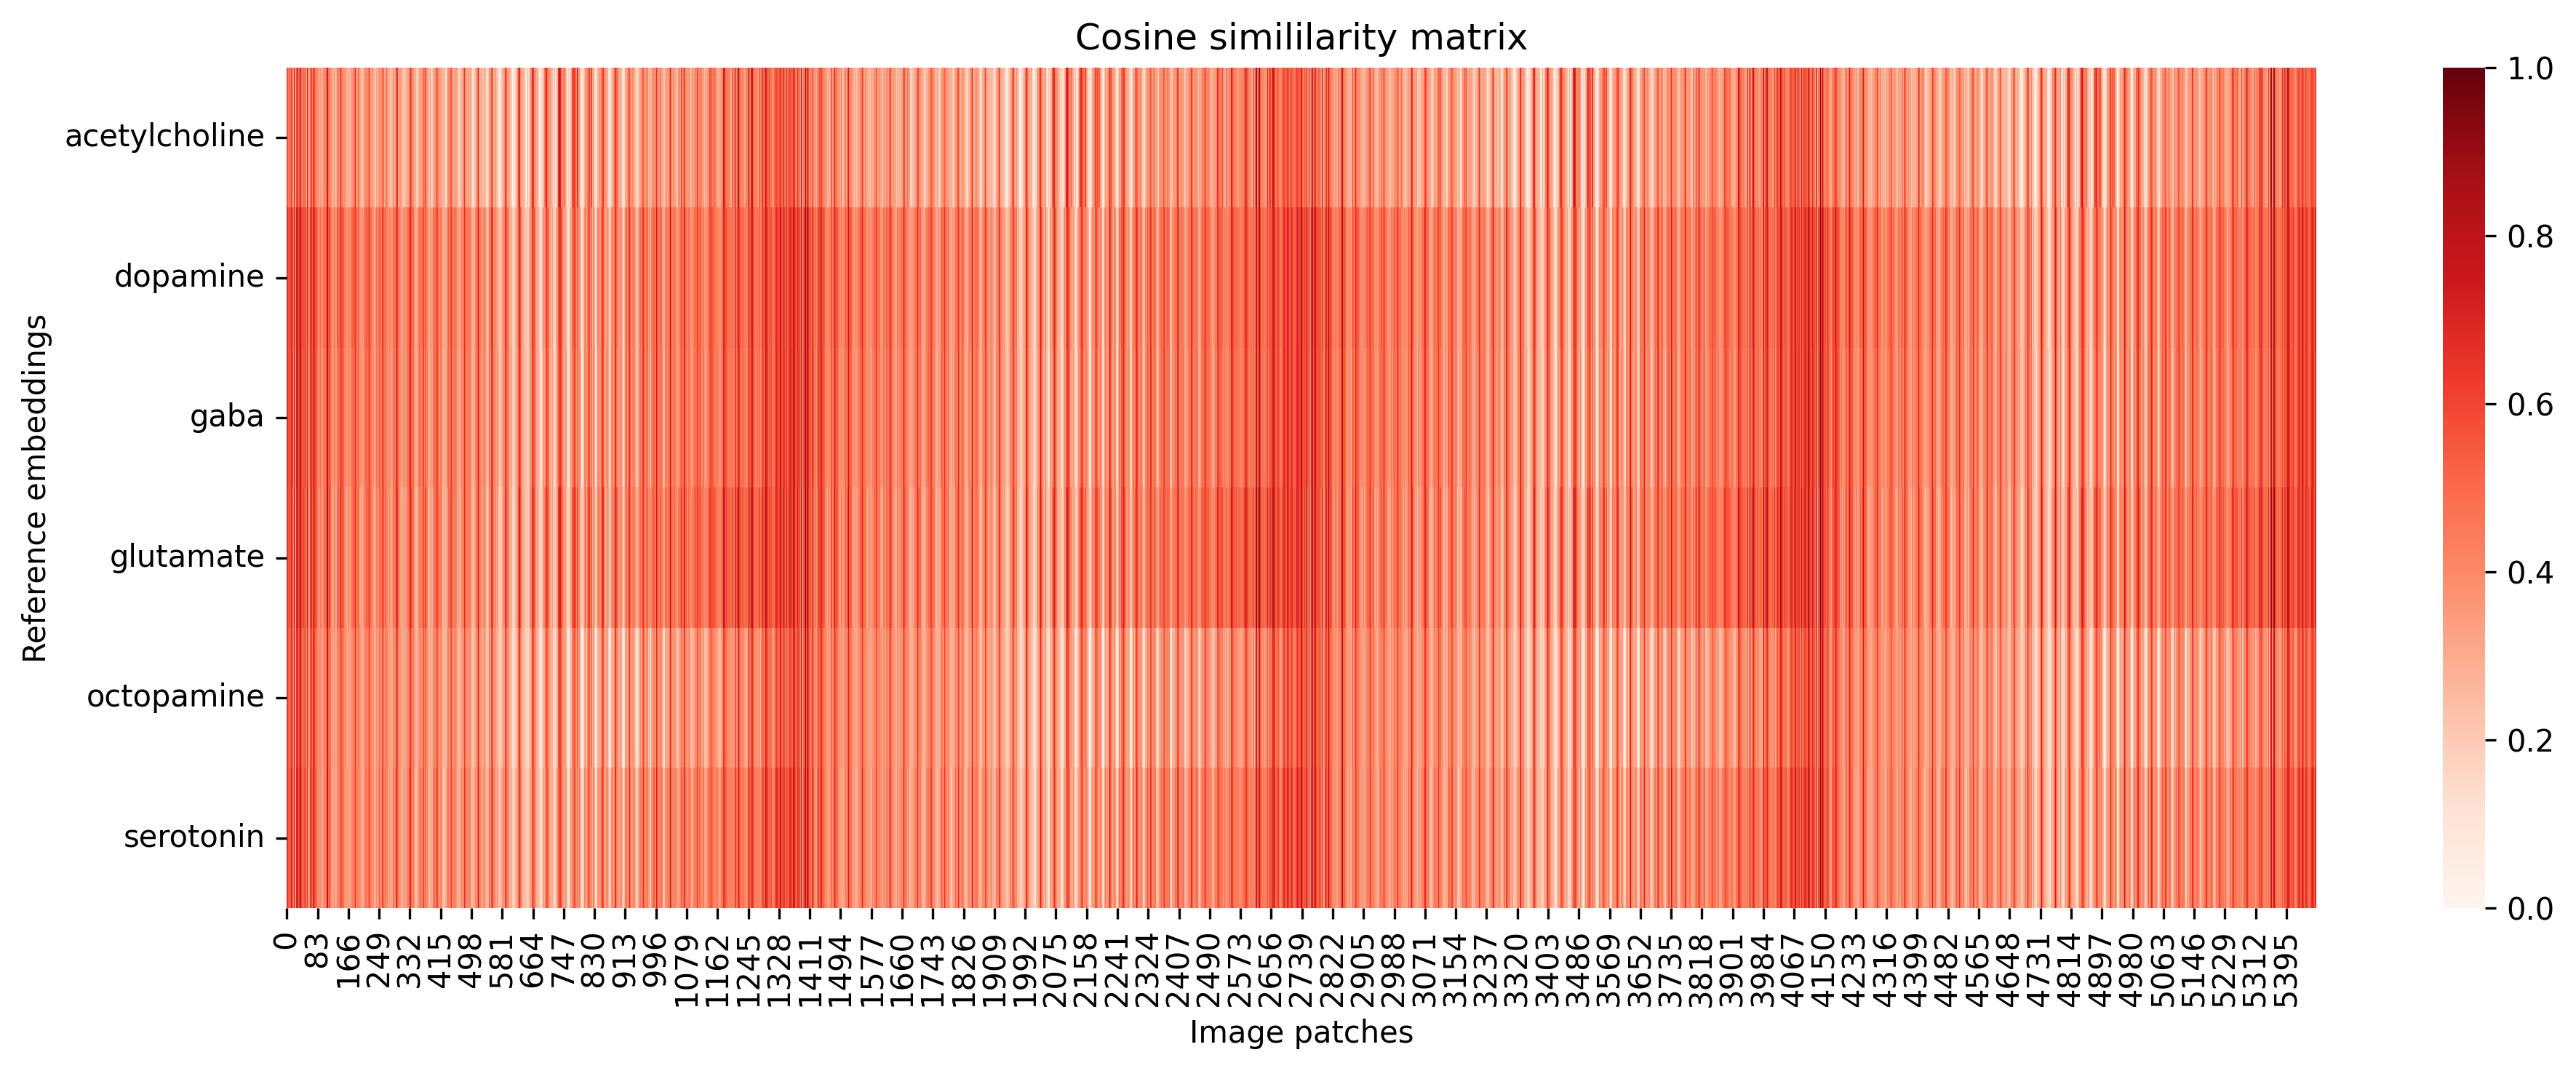

In [10]:
similarity_matrix = euclidean_distances(mean_ref, new_img_embs)
similarity_matrix_normalized = (similarity_matrix - np.min(similarity_matrix)) / (np.max(similarity_matrix) - np.min(similarity_matrix))
plt.figure(figsize=(15,5),dpi=300)
sns.heatmap(similarity_matrix_normalized, yticklabels=mean_labs, cmap='Reds')
plt.title('Cosine simililarity matrix')
plt.xlabel('Image patches')
plt.ylabel('Reference embeddings')
plt.show()

# Testing loop

In [11]:
one_hot_neurotransmitters = np.zeros((len(neurotransmitters),len(neurotransmitters))) + np.identity(len(neurotransmitters))

In [31]:
score_lists = [[],[],[],[],[],[]]

for file, label in tqdm(zip(files, labels)):

    img = np.array(load_image(file)[0])[...,np.newaxis]
    
    few_shot.pre_compute_embeddings(
            img,  # Pass numpy array of images
            overlap=(0.5, 0.5),
            padding=(0, 0),
            crop_shape=(512, 512, 1),
            verbose=False,
            batch_size=1
        )

    new_img_embs = few_shot.get_embs().reshape(-1, feat_dim)
    distance_threshold = 0.05

    similarity_matrix = euclidean_distances(mean_ref, new_img_embs)
    similarity_matrix_normalized = (similarity_matrix - np.min(similarity_matrix)) / (np.max(similarity_matrix) - np.min(similarity_matrix))

    similarity_matrix_normalized_filtered = np.where(similarity_matrix_normalized < distance_threshold, similarity_matrix_normalized, 0)
    class_wise_sum = np.sum(similarity_matrix_normalized_filtered, axis = 1)

    class_wise_sum_filtered = np.where(class_wise_sum == 0, len(new_img_embs)*distance_threshold, class_wise_sum)


    output_class = one_hot_neurotransmitters[np.argmin(class_wise_sum_filtered)]
    
    gt_index = neurotransmitters.index(label)
    ground_truth = one_hot_neurotransmitters[gt_index]
    score = np.sum(output_class*ground_truth)
    score_lists[gt_index].append(score)

0it [00:00, ?it/s]

Precomputing embeddings


1it [00:01,  1.15s/it]

Precomputing embeddings


2it [00:02,  1.10s/it]

Precomputing embeddings


3it [00:03,  1.09s/it]

Precomputing embeddings


4it [00:04,  1.08s/it]

Precomputing embeddings


5it [00:05,  1.09s/it]

Precomputing embeddings


6it [00:06,  1.08s/it]

Precomputing embeddings


7it [00:07,  1.08s/it]

Precomputing embeddings


8it [00:08,  1.08s/it]

Precomputing embeddings


9it [00:09,  1.08s/it]

Precomputing embeddings


10it [00:10,  1.09s/it]


In [ ]:
accuracies = [np.mean(scores) for scores in score_lists]

plt.figure(figsize=(12,7), dpi=300)
plt.hist(neurotransmitters, accuracies)
plt.xlabel('Classes')
plt.ylabel('Mean hard accuracy')
plt.title('Avergae accuracies across classes')